# Exploring the HI gas between an Average LAE  pair in HETDEX
Ok, we saw how we can extract and work with fiber spectra around single Lyman Alpha Emitters. This notebook shows the fiber spectra extraction & analysis on LAE pairs through studying the HI gas. Here I'm assuming that you already have selected your LAE pairs and you have a table with all their information. If you want to know about how to find pairs in the catalog, you can contact Erin, she has written a notebook about it.The goal here is to select fiber between, outwards, and perpendicular to the pairs. Let's get straight into the visuallization since it is much easier to explain it that way.

In [4]:
import numpy as np
import os.path as op
import time
import matplotlib.pyplot as plt
from astropy.table import Table, unique, join, Column, vstack, unique, hstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.visualization import ZScaleInterval
from astropy.nddata import NDData
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from hetdex_api.shot import get_fibers_table
from hetdex_api.config import HDRconfig
from hetdex_api.survey import Survey
from hetdex_api.shot import Fibers
from hetdex_api.survey import FiberIndex
from hetdex_tools.phot_tools import get_line_image, get_flux_for_source
from hetdex_tools.source_catalog import plot_source_group
from hetdex_api.elixer_widget_cls import ElixerWidget
from hetdex_api.amp_widget import AmpWidget
from hetdex_api.query_widget import QueryWidget
import hetdex_tools.fof_kdtree as fof
import healpy as hp
from multiprocessing import Pool
import pickle
from elixer import spectrum_utilities as SU

I'm going to showcase this by going through 1 pair for each of my tables. I have two tables in total, one with pairs that are really close to each other(they are both usually in the same IFU), another with pairs that lie on two different IFUs. First let's take a look at single IFU pairs. We load the data, select a pair, make a square around each LAE to an extent, and select all the fibers that lie in that two squares

In [49]:
filter_test = Table.read('filtered_pairs_table3.fits', format='fits')
row=0

In [50]:
ra_LAEs = [filter_test['ra_1'][row], filter_test['ra_2'][row]]
dec_LAEs = [filter_test['dec_1'][row], filter_test['dec_2'][row]]
coord_1 = SkyCoord(ra=ra_LAEs[0]*u.degree, dec=dec_LAEs[0]*u.degree)
coord_2 = SkyCoord(ra=ra_LAEs[1]*u.degree, dec=dec_LAEs[1]*u.degree)
dir_vector = np.array([coord_2.ra.degree - coord_1.ra.degree, coord_2.dec.degree - coord_1.dec.degree])
dir_vector /= np.linalg.norm(dir_vector)
perpendicular = np.array([-dir_vector[1], dir_vector[0]])
extension = 5/3600.0
rect_vertices = [
    [coord_1.ra.degree - extension * perpendicular[0], coord_1.dec.degree - extension * perpendicular[1]],  # Bottom left
    [coord_1.ra.degree + extension * perpendicular[0], coord_1.dec.degree + extension * perpendicular[1]],  # Top left
    [coord_2.ra.degree + extension * perpendicular[0], coord_2.dec.degree + extension * perpendicular[1]],  # Bottom right
    [coord_2.ra.degree - extension * perpendicular[0], coord_2.dec.degree - extension * perpendicular[1]]   # Top right
]

In [51]:
F = FiberIndex('hdr3')
Nside = 2 ** 15
side_length = 80/3600.0
def get_square_vertices(ra, dec, side_length):
    vec_top_left = hp.ang2vec(ra - side_length/2, dec + side_length/2, lonlat=True)
    vec_top_right = hp.ang2vec(ra + side_length/2, dec + side_length/2, lonlat=True)
    vec_bot_left = hp.ang2vec(ra - side_length/2, dec - side_length/2, lonlat=True)
    vec_bot_right = hp.ang2vec(ra + side_length/2, dec - side_length/2, lonlat=True)
    return np.vstack([vec_top_left, vec_top_right, vec_bot_right, vec_bot_left])

# Square vertices for both LAEs
vertices_LAE1 = get_square_vertices(ra_LAEs[0], dec_LAEs[0], side_length)
vertices_LAE2 = get_square_vertices(ra_LAEs[1], dec_LAEs[1], side_length)
# Query the fibers for both squares
square_region_LAE1 = hp.query_polygon(Nside, vertices_LAE1, inclusive=True)
square_region_LAE2 = hp.query_polygon(Nside, vertices_LAE2, inclusive=True)
fibers_tab = Table()
#Here, using healpix, we identify each fiber that are in the region
def get_fibers_from_region(region):
    tab = Table()
    for hpix in region:
        h_tab, h_tab_index = F.get_fib_from_hp(hpix, return_index=True)
        tab = vstack([tab, h_tab])
    return tab
fibers_in_LAE1_square = get_fibers_from_region(square_region_LAE1)
fibers_in_LAE2_square = get_fibers_from_region(square_region_LAE2)
# Merge the two fiber tables
fibers_tab = vstack([fibers_in_LAE1_square, fibers_in_LAE2_square])
fibers_tab=unique(fibers_tab, keys='fiber_id')#This will prevent selecting a fiber twice, because we want unique fibers
print(len(fibers_tab))

3387


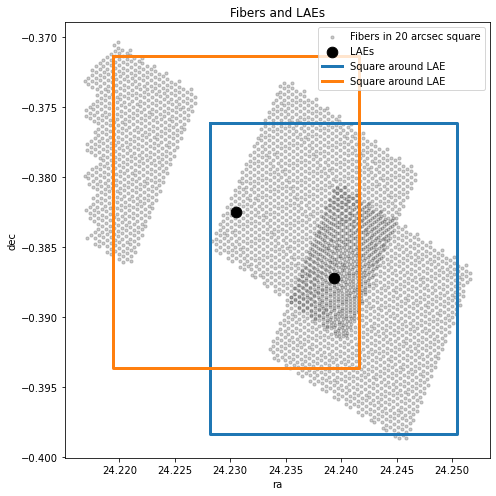

In [52]:
%matplotlib inline
def plot_square(ra, dec, side_length):
    ''' Function to plot a square given its center and side length. '''
    square_vertices_coords = [
        [ra - side_length/2, dec + side_length/2],  # top-left
        [ra + side_length/2, dec + side_length/2],  # top-right
        [ra + side_length/2, dec - side_length/2],  # bottom-right
        [ra - side_length/2, dec - side_length/2]   # bottom-left
    ]
    plt.plot(*zip(*square_vertices_coords, square_vertices_coords[0]), linestyle='-', label='Square around LAE',linewidth=3)
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='Fibers in 20 arcsec square', color='k')
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=450, label='LAEs')
plot_square(ra_LAEs[0], dec_LAEs[0], side_length)
plot_square(ra_LAEs[1], dec_LAEs[1], side_length)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.legend()
plt.tight_layout()
plt.show()

Cool, we have coverage from different shots on this pair, you can see the rough shape of each IFU here. Now we have two extract fibers based on our needs, let's say we want to stack the fibers between the pair. Two things: first, we don't want the fibers that are in the apeture of LAEs, obviiously we will see Lya Emission there and that would dominate our spectra and we wouldn't be able to see the absorption, so we get rid of fibers in the inner 3 arcsec. Second, we define a rectangle which lies within the pairs, and we apply both these filtewr to select our fibers.

In [65]:
def is_too_close_to_any_LAE(ra_fiber, dec_fiber, ra_LAEs, dec_LAEs, threshold_radius):
    for ra_LAE, dec_LAE in zip(ra_LAEs, dec_LAEs):
        dist = SkyCoord(ra=ra_fiber*u.degree, dec=dec_fiber*u.degree).separation(SkyCoord(ra=ra_LAE*u.degree, dec=dec_LAE*u.degree)).degree
        if dist < threshold_radius:
            return True
    return False

In [66]:
def is_inside_rectangle(ra, dec, vertices):
    def point_inside_triangle(p, A, B, C):
        # Check if point p is inside triangle ABC
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        d1 = sign(p, A, B)
        d2 = sign(p, B, C)
        d3 = sign(p, C, A)
        has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
        has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)
        return not (has_neg and has_pos)
    A, B, C, D = vertices
    M = [ra, dec]
    return (point_inside_triangle(M, A, B, C) or 
            point_inside_triangle(M, A, D, C) or
            point_inside_triangle(M, A, B, D) or
            point_inside_triangle(M, B, C, D))

In [67]:
mask_to_keep = []
for fiber in fibers_tab:
    mask_to_keep.append(is_inside_rectangle(fiber['ra'], fiber['dec'], rect_vertices) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600))
fibers_tab_filtered = fibers_tab[mask_to_keep]
len(fibers_tab_filtered)

232

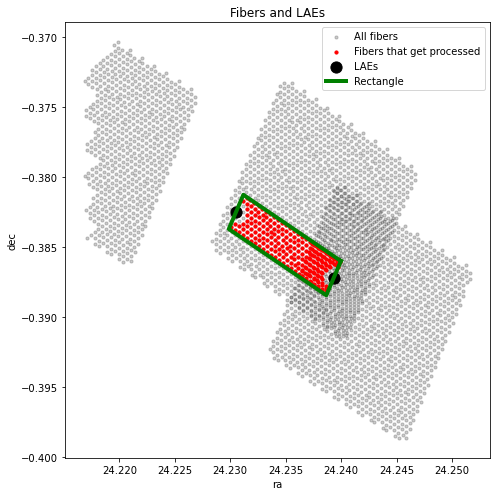

In [68]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='All fibers', color='k')

# Plot the filtered fibers (those inside the rectangle)
plt.scatter(fibers_tab_filtered['ra'], fibers_tab_filtered['dec'], color='red', s=10, label='Fibers that get processed')

# Plot the LAEs
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')

# Plot the rectangle
rect_vertices_array = np.array(rect_vertices)
plt.plot(*zip(*rect_vertices_array, rect_vertices_array[0]), color='green', linestyle='-', label='Rectangle',linewidth=4)

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.legend()
plt.tight_layout()
plt.show()


Now we do the same process that we did for the Circumgalactic Medium case. We extract the fibers, we filter them, and get a median at the end. I don't go through this since it is implemented in the python script. For instance, if you want to do this with the scipt, all you have to do is this:
#### python3 find_pairs_between_single_IFU.py 0

Then you go to the next row and so on...
Again, running this locally is possible, but computationally expensive, I recommend using TACC for this.

We can do the same thing to grab fibers outwards the pair and perpendicular the pair as well, take a look:

In [70]:
rectangle_width = 10.5/3600.0
rectangle_height = 5/3600.0 
def get_rectangle_around_point(ra, dec, dir_vector, perpendicular, width, height):
    """Generate rectangle vertices around a given RA and Dec."""
    return [
        [ra - width * perpendicular[0] - height * dir_vector[0], dec - width * perpendicular[1] - height * dir_vector[1]], # Bottom left
        [ra + width * perpendicular[0] - height * dir_vector[0], dec + width * perpendicular[1] - height * dir_vector[1]], # Bottom right
        [ra + width * perpendicular[0] + height * dir_vector[0], dec + width * perpendicular[1] + height * dir_vector[1]], # Top right
        [ra - width * perpendicular[0] + height * dir_vector[0], dec - width * perpendicular[1] + height * dir_vector[1]]  # Top left
    ]
rectangle_LAE1 = get_rectangle_around_point(ra_LAEs[0], dec_LAEs[0], dir_vector, perpendicular, rectangle_width, rectangle_height)
rectangle_LAE2 = get_rectangle_around_point(ra_LAEs[1], dec_LAEs[1], dir_vector, perpendicular, rectangle_width, rectangle_height)

In [71]:
mask_LAE1 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE1) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
mask_LAE2 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE2) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
fibers_in_LAE1_rect = fibers_tab[mask_LAE1]
fibers_in_LAE2_rect = fibers_tab[mask_LAE2]
fibers_tab_filtered = vstack([fibers_in_LAE1_rect, fibers_in_LAE2_rect])
print(len(fibers_tab_filtered))

272


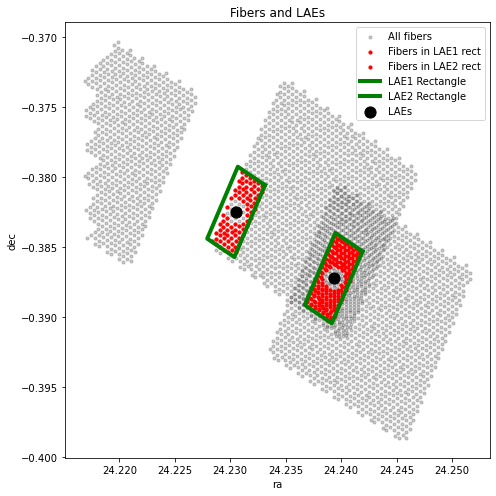

In [73]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='All fibers', color='k')
plt.scatter(fibers_in_LAE1_rect['ra'], fibers_in_LAE1_rect['dec'], color='red', s=10, label='Fibers in LAE1 rect')
plt.scatter(fibers_in_LAE2_rect['ra'], fibers_in_LAE2_rect['dec'], color='red', s=10, label='Fibers in LAE2 rect')
plt.plot(*zip(*rectangle_LAE1, rectangle_LAE1[0]), color='green', linestyle='-', label='LAE1 Rectangle',linewidth=4)
plt.plot(*zip(*rectangle_LAE2, rectangle_LAE2[0]), color='green', linestyle='-', label='LAE2 Rectangle',linewidth=4)
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.legend()
plt.tight_layout()
plt.show()

and here is the outward fibers:

In [74]:
rectangle_width = 18/3600.0 
rectangle_height = 10/3600.0 
def get_rectangle_around_point(ra, dec, dir_vector, perpendicular, width, height, left=False):
    """Generate rectangle vertices around a given RA and Dec."""
    half_height = height / 2.0
    if left:
        # Rectangle extends to the left of the LAE (LAE lies in the center of the right edge of the rectangle)
        return [
            [ra - width * dir_vector[0] - half_height * perpendicular[0], dec - width * dir_vector[1] - half_height * perpendicular[1]],
            [ra - half_height * perpendicular[0], dec - half_height * perpendicular[1]],
            [ra + half_height * perpendicular[0], dec + half_height * perpendicular[1]],
            [ra - width * dir_vector[0] + half_height * perpendicular[0], dec - width * dir_vector[1] + half_height * perpendicular[1]]
        ]
    else:
        return [
            [ra - half_height * perpendicular[0], dec - half_height * perpendicular[1]], 
            [ra + width * dir_vector[0] - half_height * perpendicular[0], dec + width * dir_vector[1] - half_height * perpendicular[1]],
            [ra + width * dir_vector[0] + half_height * perpendicular[0], dec + width * dir_vector[1] + half_height * perpendicular[1]],
            [ra + half_height * perpendicular[0], dec + half_height * perpendicular[1]] 
        ]
rectangle_LAE1_left = get_rectangle_around_point(ra_LAEs[0], dec_LAEs[0], dir_vector, perpendicular, rectangle_width, rectangle_height, left=True)
rectangle_LAE2_right = get_rectangle_around_point(ra_LAEs[1], dec_LAEs[1], dir_vector, perpendicular, rectangle_width, rectangle_height)

In [75]:
mask_LAE1 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE1_left) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
mask_LAE2 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE2_right) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
fibers_in_LAE1_rect = fibers_tab[mask_LAE1]
fibers_in_LAE2_rect = fibers_tab[mask_LAE2]
fibers_tab_filtered = vstack([fibers_in_LAE1_rect, fibers_in_LAE2_rect])
print(len(fibers_tab_filtered))

149


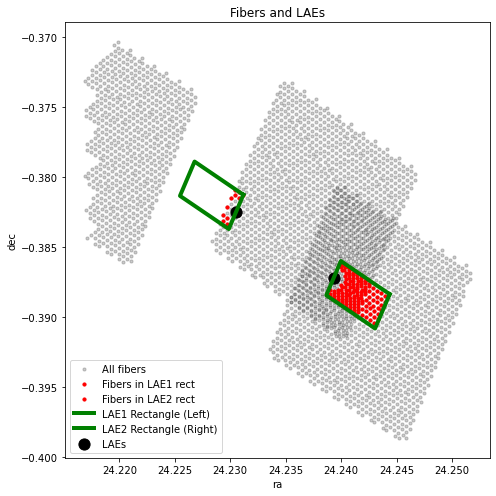

In [77]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='All fibers', color='k')
plt.scatter(fibers_in_LAE1_rect['ra'], fibers_in_LAE1_rect['dec'], color='red', s=10, label='Fibers in LAE1 rect')
plt.scatter(fibers_in_LAE2_rect['ra'], fibers_in_LAE2_rect['dec'], color='red', s=10, label='Fibers in LAE2 rect')
plt.plot(*zip(*rectangle_LAE1_left, rectangle_LAE1_left[0]), color='green', linestyle='-', label='LAE1 Rectangle (Left)',linewidth=4)
plt.plot(*zip(*rectangle_LAE2_right, rectangle_LAE2_right[0]), color='green', linestyle='-', label='LAE2 Rectangle (Right)',linewidth=4)
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')
rect_vertices_array = np.array(rect_vertices)
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.tight_layout()
plt.show()

Now one might say well this looks weird, you have like 5 fibers in the left LAE and 150 in the right LAE. That's right, and we have no control on that, but this is only 1 pair among thousands of pairs that we process, each of them look different, each have their own orientation, and this would balance out this kinda extraction

putting it all together, you can extract fibers three ways:

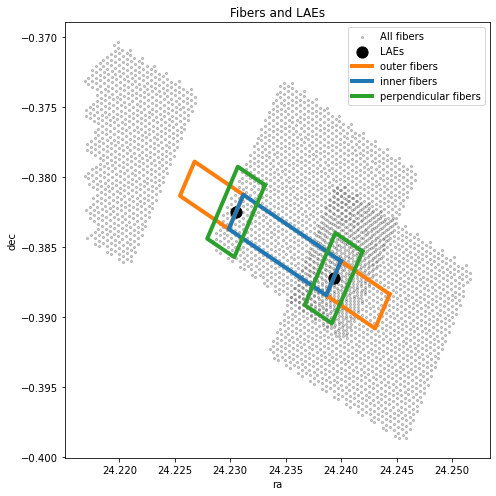

In [79]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=5, alpha=0.2, label='All fibers', color='k')
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')
plt.plot(*zip(*rectangle_LAE1_left, rectangle_LAE1_left[0]), color='tab:orange', linestyle='-', label='outer fibers', linewidth=4)
plt.plot(*zip(*rectangle_LAE2_right, rectangle_LAE2_right[0]), color='tab:orange', linestyle='-', linewidth=4)
rect_vertices_array = np.array(rect_vertices)
plt.plot(*zip(*rect_vertices_array, rect_vertices_array[0]), color='tab:blue', linestyle='-', label='inner fibers', linewidth=4) # Loop back to the first vertex to close the rectangle
plt.plot(*zip(*rectangle_LAE1, rectangle_LAE1[0]), color='tab:green', linestyle='-', label='perpendicular fibers', linewidth=4)
plt.plot(*zip(*rectangle_LAE2, rectangle_LAE2[0]), color='tab:green', linestyle='-', linewidth=4)
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.tight_layout()
plt.show()

for grabbing fibers in the blue:
#### python3 find_pairs_between_single_IFU.py 0
for grabbing fibers in the green:
#### python3 find_pairs_perpendicular.py 0
for grabbing fibers in the orange:
#### python3 find_pairs_outwards.py 0

You can do this work for multi IFU pairs as well! but with a subtle difference in the extraction. For in between pair fibers, you only extract the close fibers in the rectangle, my case for instace, I extract everything up to ~18 arcsec. Let me plot it because it's easier to explain this way:

In [98]:
filter_test = Table.read('filtered_pairs_table4.fits', format='fits')
row=13

In [99]:
ra_LAEs = [filter_test['ra_1'][row], filter_test['ra_2'][row]]
dec_LAEs = [filter_test['dec_1'][row], filter_test['dec_2'][row]]
coord_1 = SkyCoord(ra=ra_LAEs[0]*u.degree, dec=dec_LAEs[0]*u.degree)
coord_2 = SkyCoord(ra=ra_LAEs[1]*u.degree, dec=dec_LAEs[1]*u.degree)
dir_vector = np.array([coord_2.ra.degree - coord_1.ra.degree, coord_2.dec.degree - coord_1.dec.degree])
dir_vector /= np.linalg.norm(dir_vector)
perpendicular = np.array([-dir_vector[1], dir_vector[0]])
extension = 5/3600.0
rect_vertices = [
    [coord_1.ra.degree - extension * perpendicular[0], coord_1.dec.degree - extension * perpendicular[1]],  # Bottom left
    [coord_1.ra.degree + extension * perpendicular[0], coord_1.dec.degree + extension * perpendicular[1]],  # Top left
    [coord_2.ra.degree + extension * perpendicular[0], coord_2.dec.degree + extension * perpendicular[1]],  # Bottom right
    [coord_2.ra.degree - extension * perpendicular[0], coord_2.dec.degree - extension * perpendicular[1]]   # Top right
]

In [100]:
# Square vertices for both LAEs
vertices_LAE1 = get_square_vertices(ra_LAEs[0], dec_LAEs[0], side_length)
vertices_LAE2 = get_square_vertices(ra_LAEs[1], dec_LAEs[1], side_length)
# Query the fibers for both squares
square_region_LAE1 = hp.query_polygon(Nside, vertices_LAE1, inclusive=True)
square_region_LAE2 = hp.query_polygon(Nside, vertices_LAE2, inclusive=True)
fibers_tab = Table()
#Here, using healpix, we identify each fiber that are in the region
def get_fibers_from_region(region):
    tab = Table()
    for hpix in region:
        h_tab, h_tab_index = F.get_fib_from_hp(hpix, return_index=True)
        tab = vstack([tab, h_tab])
    return tab
fibers_in_LAE1_square = get_fibers_from_region(square_region_LAE1)
fibers_in_LAE2_square = get_fibers_from_region(square_region_LAE2)
# Merge the two fiber tables
fibers_tab = vstack([fibers_in_LAE1_square, fibers_in_LAE2_square])
fibers_tab=unique(fibers_tab, keys='fiber_id')#This will prevent selecting a fiber twice, because we want unique fibers
print(len(fibers_tab))

2396


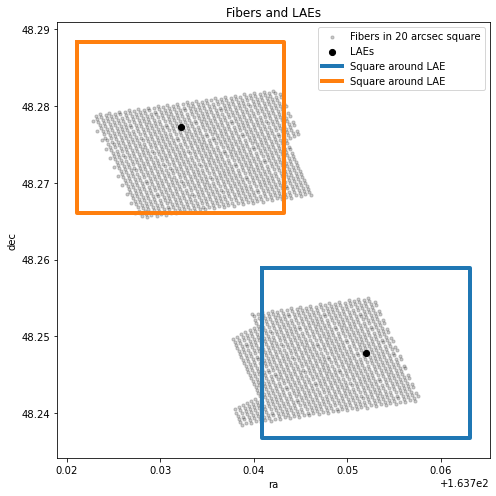

In [101]:
def plot_square(ra, dec, side_length):
    ''' Function to plot a square given its center and side length. '''
    square_vertices_coords = [
        [ra - side_length/2, dec + side_length/2],  # top-left
        [ra + side_length/2, dec + side_length/2],  # top-right
        [ra + side_length/2, dec - side_length/2],  # bottom-right
        [ra - side_length/2, dec - side_length/2]   # bottom-left
    ]
    plt.plot(*zip(*square_vertices_coords, square_vertices_coords[0]), linestyle='-', label='Square around LAE',linewidth=4)
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='Fibers in 20 arcsec square',color='k')
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=150, label='LAEs')
plot_square(ra_LAEs[0], dec_LAEs[0], side_length)
plot_square(ra_LAEs[1], dec_LAEs[1], side_length)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
mask_to_keep = []
for fiber in fibers_tab:
    mask_to_keep.append(is_inside_rectangle(fiber['ra'], fiber['dec'], rect_vertices) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius=3/3600) and is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius=18/3600))
fibers_tab_filtered = fibers_tab[mask_to_keep]
len(fibers_tab_filtered)

127

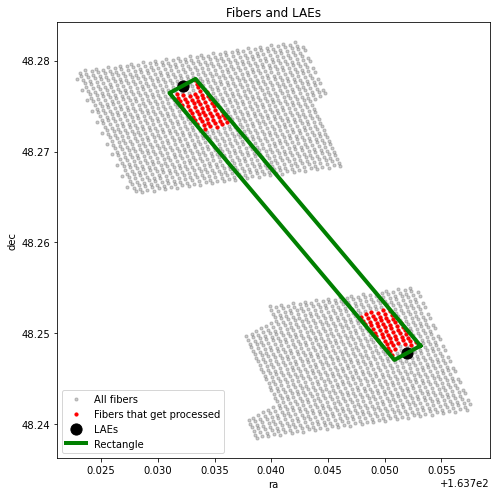

In [103]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='All fibers', color='k')

# Plot the filtered fibers (those inside the rectangle)
plt.scatter(fibers_tab_filtered['ra'], fibers_tab_filtered['dec'], color='red', s=10, label='Fibers that get processed')

# Plot the LAEs
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')

# Plot the rectangle
rect_vertices_array = np.array(rect_vertices)
plt.plot(*zip(*rect_vertices_array, rect_vertices_array[0]), color='green', linestyle='-', label='Rectangle',linewidth=4)

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.legend()
plt.tight_layout()
plt.show()


you see the difference here is very clear, I'm not grabbing all the fibers in the rectangle, only the close ones to the LAEs. Why? because then I can compare the stacked spectra for both kind of pairs. If I see an absorption in close pairs, the absorption in distant pairs better be weaker if any. The whole idea here is to see that if we can identify high density HI regions through the Lyman Alpha absorption line.

perpendicular again:

In [116]:
rectangle_width = 10.5/3600.0
rectangle_height = 5/3600.0 
def get_rectangle_around_point(ra, dec, dir_vector, perpendicular, width, height):
    """Generate rectangle vertices around a given RA and Dec."""
    return [
        [ra - width * perpendicular[0] - height * dir_vector[0], dec - width * perpendicular[1] - height * dir_vector[1]], # Bottom left
        [ra + width * perpendicular[0] - height * dir_vector[0], dec + width * perpendicular[1] - height * dir_vector[1]], # Bottom right
        [ra + width * perpendicular[0] + height * dir_vector[0], dec + width * perpendicular[1] + height * dir_vector[1]], # Top right
        [ra - width * perpendicular[0] + height * dir_vector[0], dec - width * perpendicular[1] + height * dir_vector[1]]  # Top left
    ]
rectangle_LAE1 = get_rectangle_around_point(ra_LAEs[0], dec_LAEs[0], dir_vector, perpendicular, rectangle_width, rectangle_height)
rectangle_LAE2 = get_rectangle_around_point(ra_LAEs[1], dec_LAEs[1], dir_vector, perpendicular, rectangle_width, rectangle_height)

In [117]:
mask_LAE1 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE1) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
mask_LAE2 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE2) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
fibers_in_LAE1_rect = fibers_tab[mask_LAE1]
fibers_in_LAE2_rect = fibers_tab[mask_LAE2]
fibers_tab_filtered = vstack([fibers_in_LAE1_rect, fibers_in_LAE2_rect])
print(len(fibers_tab_filtered))

120


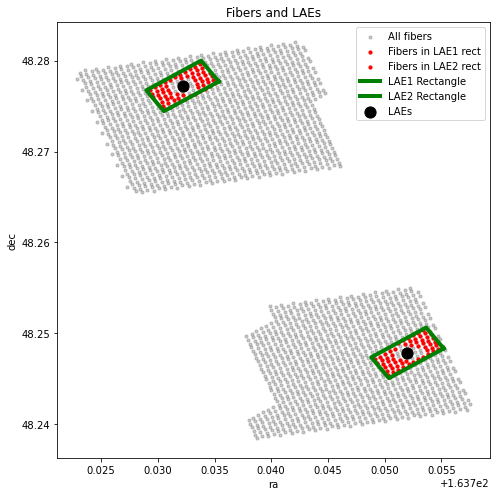

In [118]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='All fibers', color='k')
plt.scatter(fibers_in_LAE1_rect['ra'], fibers_in_LAE1_rect['dec'], color='red', s=10, label='Fibers in LAE1 rect')
plt.scatter(fibers_in_LAE2_rect['ra'], fibers_in_LAE2_rect['dec'], color='red', s=10, label='Fibers in LAE2 rect')
plt.plot(*zip(*rectangle_LAE1, rectangle_LAE1[0]), color='green', linestyle='-', label='LAE1 Rectangle',linewidth=4)
plt.plot(*zip(*rectangle_LAE2, rectangle_LAE2[0]), color='green', linestyle='-', label='LAE2 Rectangle',linewidth=4)
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.legend()
plt.tight_layout()
plt.show()

and outwards:

In [119]:
rectangle_width = 18/3600.0 
rectangle_height = 10/3600.0 
def get_rectangle_around_point(ra, dec, dir_vector, perpendicular, width, height, left=False):
    """Generate rectangle vertices around a given RA and Dec."""
    half_height = height / 2.0
    if left:
        # Rectangle extends to the left of the LAE (LAE lies in the center of the right edge of the rectangle)
        return [
            [ra - width * dir_vector[0] - half_height * perpendicular[0], dec - width * dir_vector[1] - half_height * perpendicular[1]],
            [ra - half_height * perpendicular[0], dec - half_height * perpendicular[1]],
            [ra + half_height * perpendicular[0], dec + half_height * perpendicular[1]],
            [ra - width * dir_vector[0] + half_height * perpendicular[0], dec - width * dir_vector[1] + half_height * perpendicular[1]]
        ]
    else:
        return [
            [ra - half_height * perpendicular[0], dec - half_height * perpendicular[1]], 
            [ra + width * dir_vector[0] - half_height * perpendicular[0], dec + width * dir_vector[1] - half_height * perpendicular[1]],
            [ra + width * dir_vector[0] + half_height * perpendicular[0], dec + width * dir_vector[1] + half_height * perpendicular[1]],
            [ra + half_height * perpendicular[0], dec + half_height * perpendicular[1]] 
        ]
rectangle_LAE1_left = get_rectangle_around_point(ra_LAEs[0], dec_LAEs[0], dir_vector, perpendicular, rectangle_width, rectangle_height, left=True)
rectangle_LAE2_right = get_rectangle_around_point(ra_LAEs[1], dec_LAEs[1], dir_vector, perpendicular, rectangle_width, rectangle_height)

In [120]:
mask_LAE1 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE1_left) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
mask_LAE2 = [is_inside_rectangle(fiber['ra'], fiber['dec'], rectangle_LAE2_right) and not is_too_close_to_any_LAE(fiber['ra'], fiber['dec'], ra_LAEs, dec_LAEs, threshold_radius= 3/3600) for fiber in fibers_tab]
fibers_in_LAE1_rect = fibers_tab[mask_LAE1]
fibers_in_LAE2_rect = fibers_tab[mask_LAE2]
fibers_tab_filtered = vstack([fibers_in_LAE1_rect, fibers_in_LAE2_rect])
print(len(fibers_tab_filtered))

94


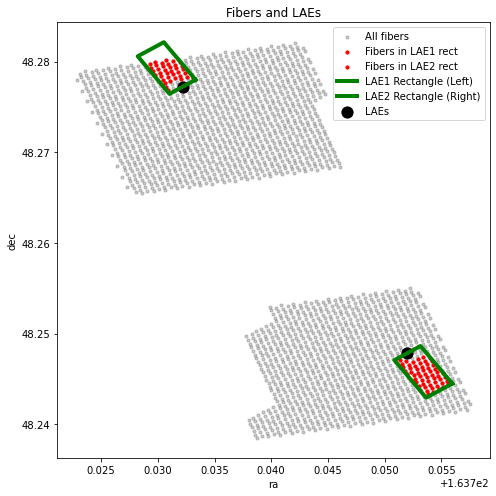

In [121]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=10, alpha=0.2, label='All fibers', color='k')
plt.scatter(fibers_in_LAE1_rect['ra'], fibers_in_LAE1_rect['dec'], color='red', s=10, label='Fibers in LAE1 rect')
plt.scatter(fibers_in_LAE2_rect['ra'], fibers_in_LAE2_rect['dec'], color='red', s=10, label='Fibers in LAE2 rect')
plt.plot(*zip(*rectangle_LAE1_left, rectangle_LAE1_left[0]), color='green', linestyle='-', label='LAE1 Rectangle (Left)',linewidth=4)
plt.plot(*zip(*rectangle_LAE2_right, rectangle_LAE2_right[0]), color='green', linestyle='-', label='LAE2 Rectangle (Right)',linewidth=4)
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')
rect_vertices_array = np.array(rect_vertices)
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.tight_layout()
plt.show()

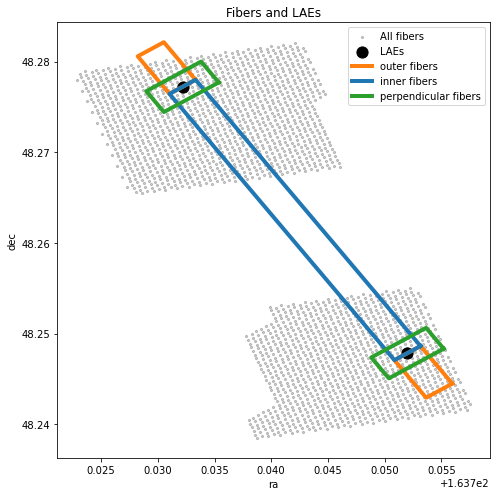

In [122]:
plt.figure(figsize=(7,7))
plt.scatter(fibers_tab['ra'], fibers_tab['dec'], s=5, alpha=0.2, label='All fibers', color='k')
plt.scatter(ra_LAEs, dec_LAEs, color='k', marker='.', s=500, label='LAEs')
plt.plot(*zip(*rectangle_LAE1_left, rectangle_LAE1_left[0]), color='tab:orange', linestyle='-', label='outer fibers', linewidth=4)
plt.plot(*zip(*rectangle_LAE2_right, rectangle_LAE2_right[0]), color='tab:orange', linestyle='-', linewidth=4)
rect_vertices_array = np.array(rect_vertices)
plt.plot(*zip(*rect_vertices_array, rect_vertices_array[0]), color='tab:blue', linestyle='-', label='inner fibers', linewidth=4) # Loop back to the first vertex to close the rectangle
plt.plot(*zip(*rectangle_LAE1, rectangle_LAE1[0]), color='tab:green', linestyle='-', label='perpendicular fibers', linewidth=4)
plt.plot(*zip(*rectangle_LAE2, rectangle_LAE2[0]), color='tab:green', linestyle='-', linewidth=4)
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Fibers and LAEs')
plt.tight_layout()
plt.show()

And all you need to do for each case is:
for grabbing fibers in the blue:
#### python3 find_pairs_between_multi_IFU.py 0     
notice the change from single to multi
for grabbing fibers in the green:
#### python3 find_pairs_perpendicular.py 0
for grabbing fibers in the orange:
#### python3 find_pairs_outwards.py 0

I said too much I guess, could've been less redundant, but the bottom line is all you need to do is using the specific script for each pair, depending on what fibers you want. 
#### please don't hesitate to message me on Slack for any questions @Mahan Mirza Khanlari